# Read in the data

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
survey_sat_corr = combined[survey_fields].corrwith(combined["sat_score"])
survey_sat_corr

rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_11      0.036906
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
dtype: float64

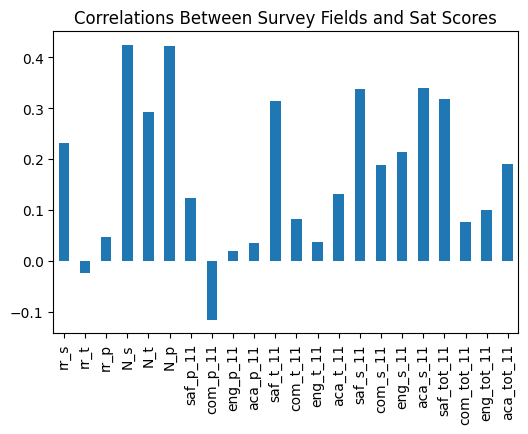

In [13]:
survey_sat_corr.plot(kind='bar', legend=False)
plt.title("Correlations Between Survey Fields and Sat Scores")
plt.show()

There seems to be a small positive correlations between the number of respondents(Student, teacher, and parents) and the sat_scores. This shows that schools with higher engagement have students that produce higher test results. In addition, the bar graph shows a high correlation between perceived school safety/respect scores and sat results.

# Exploring Safety and SAT Scores

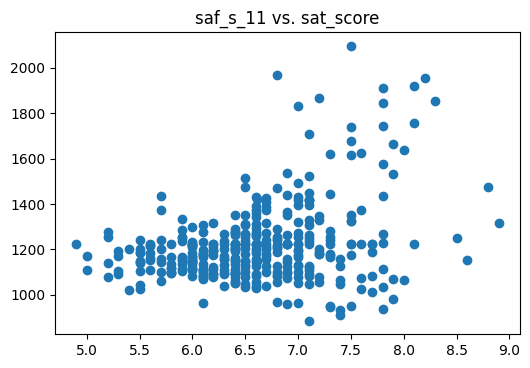

In [14]:
plt.scatter(combined["saf_s_11"], combined["sat_score"])
plt.title("saf_s_11 vs. sat_score")
plt.show()

The results above plot the student perceived safety scores against the sat scores for schools in the district. The graph displays a positive trend where schools with higher saf_s_11 scores achiever higher sat_scores overall.

In [15]:
combined_draft = combined.copy()

In [16]:
#combined_draft.groupby("boro")
#combined_draft[["boro","saf_t_11"]]
boroughs = combined_draft["boro"].unique()
boroughs
mean_values = {}

In [17]:
for b in boroughs:
    subset = combined[combined["boro"] == b]
    mean_saf = subset["saf_t_11"].mean()
    mean_values[b] = mean_saf
    
print(mean_values)    

{'Manhattan': 7.2877777777777775, 'Bronx': 7.026881720430109, 'Brooklyn': 6.985849056603773, 'Queens': 7.365625, 'Staten Island': 7.209999999999999}


We created an array that holds the values of the different boroughs in New York accompanied by their mean schools safety score. The results show that Queens and Manhattan have the highest safety scores, while Brooklyn has the lowest.

# Exploring Race and SAT Scores

In [18]:
race_cols = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined_draft[race_cols]

,white_per,asian_per,black_per,hispanic_per
0,1.7,14.0,29.1,53.8
1,2.3,29.2,22.6,45.9
2,10.4,9.7,23.9,55.4
3,1.6,9.3,31.6,56.9
4,44.9,27.8,11.7,14.2
...,...,...,...,...
358,0.7,1.7,9.2,88.1
359,1.8,0.5,28.3,68.7
360,1.0,1.5,26.4,70.4
361,1.5,5.3,12.9,79.5


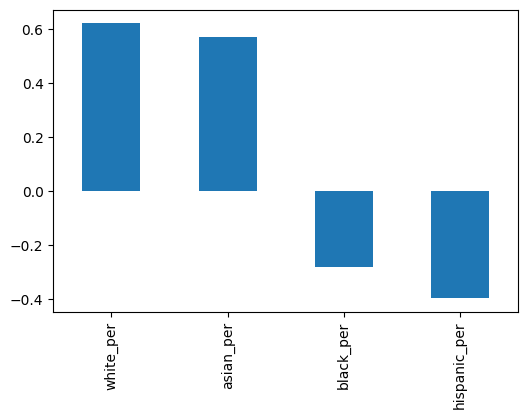

In [19]:
race_sat_corr = combined_draft[race_cols].corrwith(combined_draft["sat_score"])
race_sat_corr.plot(kind="bar", legend=False)
title = ("Race vs. SAT scores in Schools in New York")
plt.show()

results show a positive but medium correlation between Caucasian and Asian races and sat scores. On the other hand, black and hispanic races had minor negative correlation with test scores.

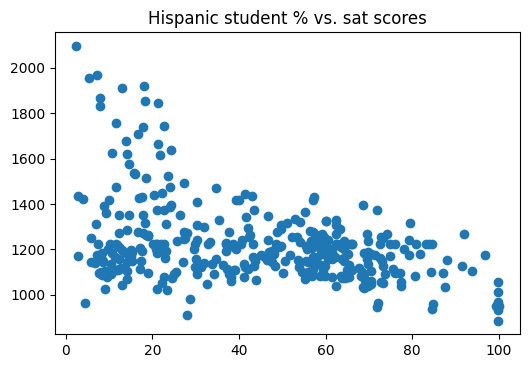

In [20]:
plt.scatter(combined_draft["hispanic_per"], combined_draft["sat_score"])
plt.title("Hispanic student % vs. sat scores")
plt.show()

The downward trend shows that schools with higher hispanic percentages in New York have overall lower sat scores.

In [21]:
combined_draft["SCHOOL NAME"][combined_draft["hispanic_per"] > 95] # shows all schools in the data where the "hispanic per" is greater than 95%

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The above schools are predominantly Hispanic in the New York City as they are located in neighbourhoods with high populations of Hispanic residents. Additionally, some o these schools may have a specific focus on serving the community by offering bilingual education programs that cater to the city's predominant cultural background.

In [22]:
combined_draft["SCHOOL NAME"][(combined_draft["hispanic_per"] < 10) & (combined_draft["sat_score"] > 1800)] # Displays schools in the region where hispance percentage is less than 10% and the avg sat scores is above 1800

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools with low hispanic percentage and high sat scores have prestigiuos characteristics that seperate them from other schools. The acceptance rate for these schools is often much lower than traditional highschools with some reporting only admitting 800 of 30 000 total applicants. Admission to these schools is granted via examinations that dictate the students acceptance. Many of the bright figures in our world have come from these high schools.

# Exploring Gender and SAT Scores

In [23]:
gender_cols = ["male_per", "female_per"]
gender_sat_corr = combined_draft[gender_cols].corrwith(combined["sat_score"])
gender_sat_corr

male_per     -0.112062
female_per    0.112108
dtype: float64

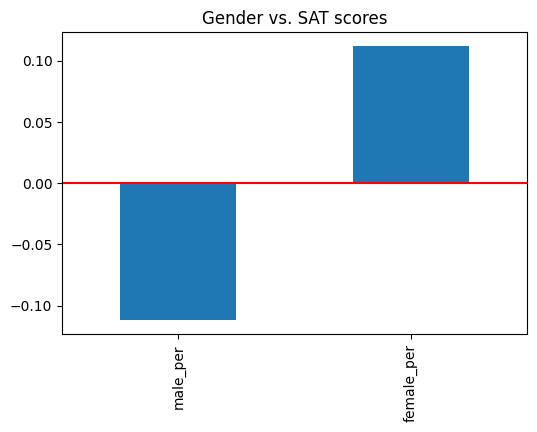

In [24]:
gender_sat_corr.plot(kind="bar", legend=False)
plt.axhline(y=0.00, color='red', linestyle='-')
plt.title("Gender vs. SAT scores")
plt.show()

The findings show that the correlation between a schools male demographic percent is negative although small. This is surprising as it indicates that schools with increased male demographics tend to produce lower overall SAT scores. On the contrary, female percentage in highschools had a positive but minor correlation with sat scores.

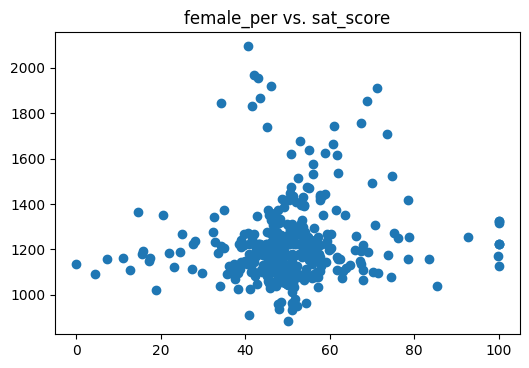

In [25]:
plt.scatter(combined_draft["female_per"], combined_draft["sat_score"])
plt.title("female_per vs. sat_score")
plt.show()

Looking at the scatter plot, no real correlation can be derived from the image above. The values are clustered around the center of the graph. The uniformity of values produce the image above. 

In [26]:
combined_draft["SCHOOL NAME"][(combined_draft["female_per"] > 60) & (combined_draft["sat_score"] > 1700)]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Through research it was found the schools above are specialized in areas that help students develop skills that are demanded in post-secondary education. Furthermore, many of these highschools have below average accpetacne rates, making them more prestigious than regular schools in new york

# Exploring AP Scores vs. SAT Scores

In [27]:
combined_draft["ap_per"] = combined_draft["AP Test Takers "] / combined_draft["total_enrollment"]
combined_draft["ap_per"]

0      0.305756
1      0.098985
2      0.031773
3      0.351577
4      0.158091
         ...   
358    0.077558
359    0.297301
360    0.190955
361    0.026616
362    0.073593
Name: ap_per, Length: 363, dtype: float64

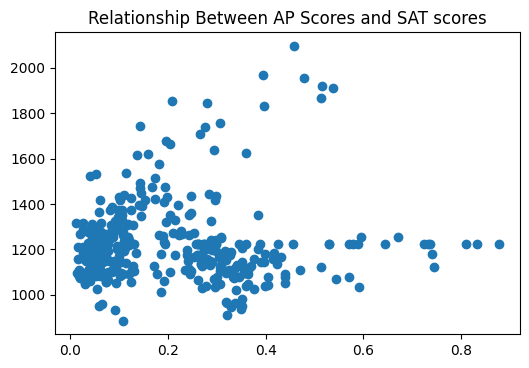

In [28]:
plt.scatter(combined_draft["ap_per"], combined_draft["sat_score"])
plt.title("Relationship Between AP Scores and SAT scores")
plt.show()

In [29]:
combined_draft["ap_per"].corr(combined["sat_score"])

0.05717081390766969

The scatter plot shows a very minor but positive correlation between AP scores and SAT scores.

# Class Size and SAT Scores

In [31]:
print(combined_draft.columns)

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'priority06', 'priority07', 'priority08', 'priority09', 'priority10',
       'Location 1', 'lat', 'lon', 'school_dist', 'ap_per'],
      dtype='object', length=161)


# Conclusions

Analyzing the 5 district boroughs in New York City allows us to derive insights based on the highschools and the performance of students in the region. Our findings include:
- According to school safety surveys, Manhattan is the safest borough in NYC
- Schools with higher percentages of White and Asian race students tend to produce overall better SAT scores than black or hispanic race predominant schools
- There is seemingly a downward trend between percent of hispanics at a given highschool and that schools overall SAT performance
- Genders distribution also affects the range of SAT scores across highschools in NY. Although the correlations are almost negligible, schools with a higher male demogrpahic performed worse on SAT's than higher female demographic schools.
- Finally, no relationship was found between schools that offered AP courses and that schools average SAT score.